## Newcomer Task edits in the AB variant test – Regression models

The approach for fitting regression models to predict whether users are likely to make newcomer task edits is the same as we've used in the previous analysis of this A/B variant test. Because the outcome is binary, either a user edited or they didnt', we use a logistic regression model. We add predictors iteratively until we find the most likely model. Like before, we have predictors for which variant the user had, whether they registered on desktop or mobile, and when they registered (in time since the start of the experiment).

In [85]:
# https://stackoverflow.com/a/35018739/1091835
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [ ]:
## libraries

library(data.table)
library(ggplot2)

library(lme4)

library(caret)

library(interactions)
library(multcomp)
library(emmeans)

library(ROCR)

## Configuration variables

In [80]:
## Set BLAS threads to 4 so glmer doesn't use all cores
library(RhpcBLASctl)
blas_set_num_threads(4)

## parallelization
options(mc.cores = 4)

### Helper functions

In [86]:
## Function that takes in a model, the validation set, the name of the predicted column,
## and returns a plot of the ROC curve
plot_ROC = function(mod, val_data, col_name, plot_title, cutoff_steps = 0.1) {
  preds = predict(mod, val_data, type = "response")
  ROCR_pred = prediction(preds, val_data[[col_name]])
  ROCR_perf = performance(ROCR_pred, "tpr", "fpr")
  plot(ROCR_perf, colorize = TRUE, print.cutoffs.at = seq(0, 1, by = cutoff_steps),
       text.adj = c(-0.2, 1.7), main = plot_title)
}

## Function to output a confusion matrix
confusion_matrix = function(model_predictions, threshold, reference, levels = c("yes", "no")) {
  pred = factor(ifelse(model_predictions >= threshold, levels[1], levels[2]), levels = levels)
  truth = factor(ifelse(reference, levels[1], levels[2]), levels = levels)
  confusionMatrix(pred, truth, mode = 'prec_recall')
}


### Data import and setup

In [3]:
tagged_edits = fread('datasets/variant-test-1-tagged-edit-counts.tsv',
                     colClasses = c(wiki = 'factor', user_registration = 'character'))

Our dataset contains this many registrations in total:

In [39]:
length(tagged_edits[hp_enabled == 1]$wiki)

[1] 68575

Note that the dataset does not include known test accounts, users who were in the control group (meaning they didn't have the Homepage enabled upon registration), or users who turned the Homepage on/off during the experiment.

In [5]:
## Configuration variables for this experiment.
## Start timestamp is from https://phabricator.wikimedia.org/T238888#5738223
start_ts = as.POSIXct('2019-12-13 00:32', tz = 'UTC')
end_ts = as.POSIXct('2020-05-15 00:00', tz = 'UTC')

## Convert user_registration into a timestamp
tagged_edits[, user_reg_ts := as.POSIXct(user_registration, format = '%Y%m%d%H%M%S', tz = 'UTC')]

## Calculate time since start of experiment in weeks
tagged_edits[, exp_days := 0]
tagged_edits[, exp_days := difftime(user_reg_ts, start_ts, units = "days")]
tagged_edits[, ln_exp_days := log(1 + as.numeric(exp_days))]
tagged_edits[, ln_exp_weeks := log(1 + as.numeric(exp_days)/7)]

## Convert all NAs to 0, from
## https://stackoverflow.com/questions/7235657/fastest-way-to-replace-nas-in-a-large-data-table
na_to_zero = function(DT) {
  # or by number (slightly faster than by name) :
  for (j in seq_len(ncol(DT)))
    set(DT,which(is.na(DT[[j]])),j,0)
}

na_to_zero(tagged_edits)

## Create boolean column for whether the user edited
tagged_edits[, did_edit := num_edits > 0]

## Drop the bot_by_name and bot_by_group columns
tagged_edits[, bot_by_name := NULL]
tagged_edits[, bot_by_group := NULL]

## set the random seed so train/test/validation splits can be reproduced
set.seed(42)

## Remove all control group users, split the rest out into training, testing, and validation datasets
exp_users = tagged_edits[hp_enabled == 1]

trainIndex <- createDataPartition(exp_users$nt_pre_enabled,
                                  p = .8, 
                                  list = FALSE, 
                                  times = 1)
exp_users_train = exp_users[trainIndex,]
exp_users_second = exp_users[-trainIndex,]

testIndex = createDataPartition(exp_users_second$nt_pre_enabled, p = .5, list = FALSE, times = 1)

exp_users_test = exp_users_second[testIndex,]
exp_users_validate = exp_users_second[-testIndex,]


## Variant A/B as a predictor

In this first model, we predict whether the user edited based on the variant the user was in, while allowing the overall probability of editing to vary by wiki.

In [76]:
## 1: only variant as a predictor:
edit.model.1 = glmer(formula = did_edit ~ nt_pre_enabled + (1 | wiki),
                    family = binomial(link = "logit"), data = exp_users_train)

In [7]:
summary(edit.model.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_edit ~ nt_pre_enabled + (1 | wiki)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
  5640.6   5667.3  -2817.3   5634.6    54857 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.1121 -0.1102 -0.0919 -0.0919 14.5466 

Random effects:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.07727  0.278   
Number of obs: 54860, groups:  wiki, 4

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -4.63854    0.15594 -29.746  < 2e-16 ***
nt_pre_enabled -0.36284    0.09142  -3.969 7.22e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
nt_pre_nbld -0.238

This model indicates that variant B is associated with a lower probability of editing, -9% (-0.36/4) compared to variant A. We also see that the predictor is statistically significant. This result also reflects the overall trend indicates in the dataset, that comparing the variant directly suggestes that variant B fares poorer.

We plot an Receiver Operating Curve for this model to get a sense of its performance:

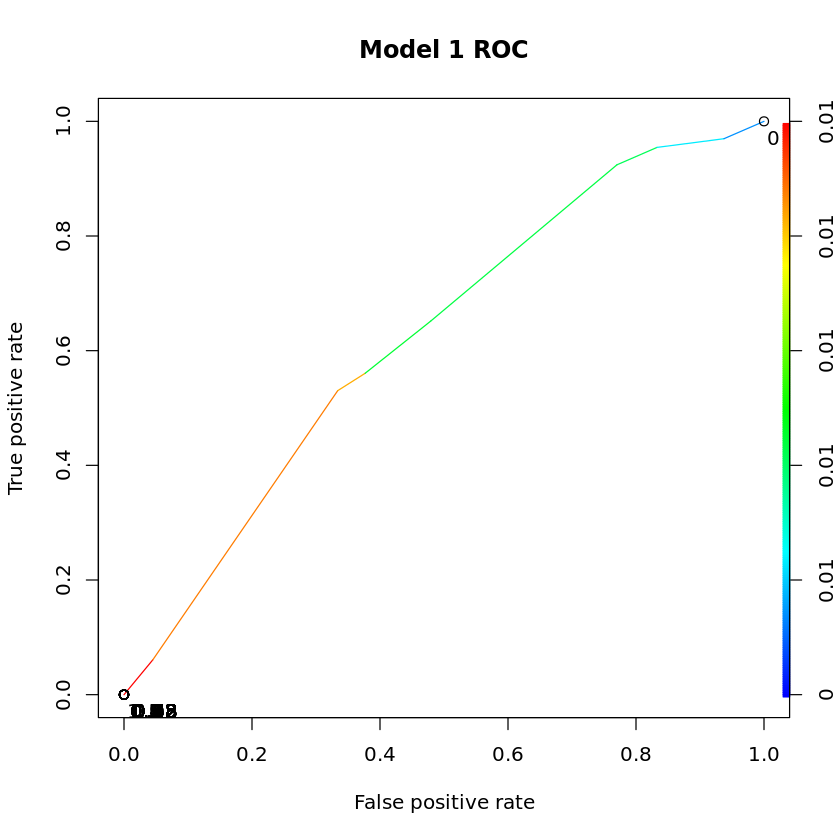

In [46]:
plot_ROC(edit.model.1, exp_users_validate, 'did_edit', "Model 1 ROC", cutoff_steps = 0.025)

This is not an excellent ROC curve, the good ones have a line that goes up and to the left in the graph (low false positive rate, high true positive rate). However, it does show some improvement over random, which is a straight diagonal line. Question is, do other models fare better? We've previously seen a strong interaction between variant and desktop/mobile, so we'll at least have to investigate that.

## Desktop/mobile registration

We add whether the user registered on desktop or mobile as a predictor.

In [77]:
## 2: add desktop/mobile
edit.model.2 = glmer(formula = did_edit ~ nt_pre_enabled + reg_on_mobile + (1 | wiki),
                    family = binomial(link = "logit"), data = exp_users_train)


In [49]:
summary(edit.model.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_edit ~ nt_pre_enabled + reg_on_mobile + (1 | wiki)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
  5614.8   5650.4  -2803.4   5606.8    54856 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.1309 -0.1062 -0.0938 -0.0782 16.5797 

Random effects:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.07416  0.2723  
Number of obs: 54860, groups:  wiki, 4

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -4.91290    0.16472 -29.826  < 2e-16 ***
nt_pre_enabled -0.36257    0.09151  -3.962 7.43e-05 ***
reg_on_mobile   0.52003    0.10106   5.146 2.66e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) nt_pr_
nt_pre_nbld -0.227       
reg_on_mobl -0.360  0.000

We see that where the user registers also has a strong effect on their likelyhood of making a tagged edit. Here we see a 13% (0.52/4) higher likelihood if the user is on mobile. We also see that this model has higher fitness compared to the first model, the BIC is 17 points lower, which is generally regarded as clear indication that the second model is better. These results are consistent with what we've seen in previous analysis of Homepage interactions.

## Interaction between variant and desktop/mobile

One of the key findings of our previous analysis was that there was a strong interaction effect between which variant group the user was in, and whether they registered on desktop or mobile. An *interaction effect* means that the effect of one of the predictors is altered by the effect of another predictor. In our case, since both predictor are binary categorical variables, it means that the outcome is altered depending on the combination of those categories.

In [79]:
## 3: desktop/mobile interaction
edit.model.3 = glmer(formula = did_edit ~ nt_pre_enabled * reg_on_mobile + (1 | wiki),
                    family = binomial(link = "logit"), data = exp_users_train)

In [51]:
summary(edit.model.3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_edit ~ nt_pre_enabled * reg_on_mobile + (1 | wiki)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
  5608.1   5652.7  -2799.1   5598.1    54855 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.1354 -0.1030 -0.0933 -0.0834 15.1270 

Random effects:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.07309  0.2704  
Number of obs: 54860, groups:  wiki, 4

Fixed effects:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -5.09360    0.17907 -28.445  < 2e-16 ***
nt_pre_enabled                0.03185    0.16139   0.197  0.84355    
reg_on_mobile                 0.77280    0.13623   5.673 1.41e-08 ***
nt_pre_enabled:reg_on_mobile -0.57967    0.19681  -2.945  0.00323 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effect

This model indicates that the interaction between variants and desktop/mobile is again strong. We find as follows:

1. On desktop there is no significant difference in probability of making a tagged edit between the two variants. This is shown by `nt_pre_enabled` not being a significant predictor on its own.
2. Mobile continues to be a strong indicator of the user making a tagged edit in Variant A.
3. If the user is in Variant B and on mobile, they're less likely to make a tagged edit.

Given that we know from previous analysis that interaction are stronger in variant B on desktop, it's worth asking if there's something in the design of the mobile Homepage that should result in a much lower probability of making a tagged edit in variant B. E.g. we know that mobile users are more likely to have been attempting to edit because there's an overlay across the screen if they do so without logging in, does that interfere with the Newcomer Task module?

We plot an ROC curve for this model similarly as we did for model 1 to get a sense of whether we've improved our prediction accuracy.

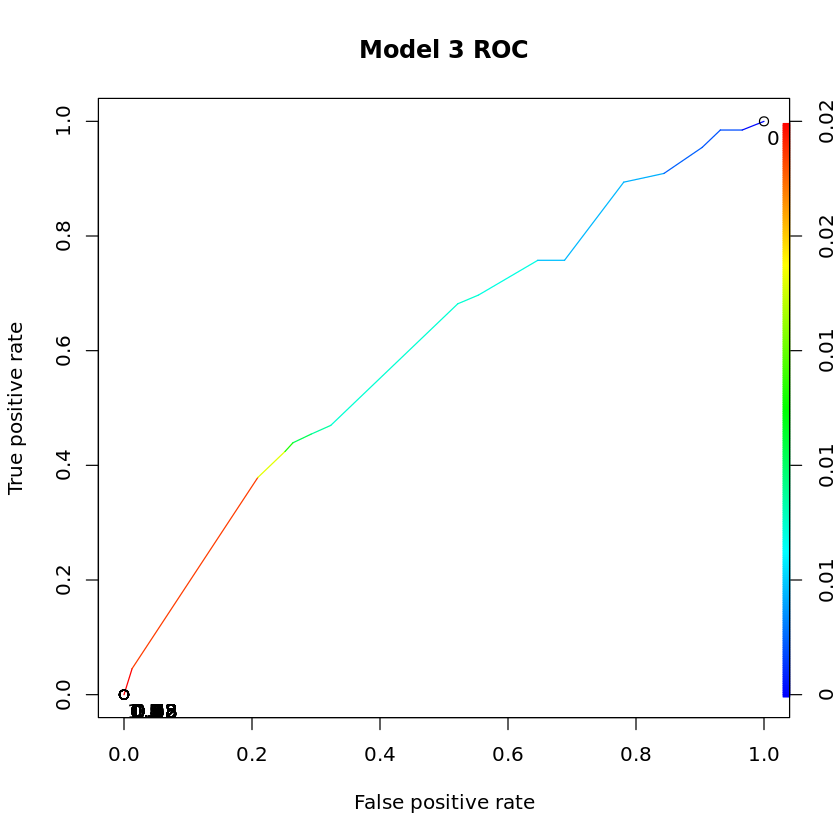

In [56]:
plot_ROC(edit.model.3, exp_users_validate, 'did_edit', "Model 3 ROC", cutoff_steps = 0.025)

## Variation across wikis

We test if the effect of these predictors vary significantly by wiki.

In [54]:
## 4: add experiment time, using log weeks
edit.model.4 = glmer(formula = did_edit ~ nt_pre_enabled * reg_on_mobile +
                      (1 + nt_pre_enabled * reg_on_mobile | wiki),
                    family = binomial(link = "logit"), data = exp_users_train)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0120301 (tol = 0.002, component 1)”


In [55]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(edit.model.4, c("theta", "fixef"))
edit.model.4 = update(edit.model.4, start = start_vals,
                     control = glmerControl(optCtrl = list(maxfun = 2e4)))


boundary (singular) fit: see ?isSingular



The model converges, but we get a warning that the fit is "singular". From previous analyses, we've learned that this means that the variation between wikis is not large enough to be detectable. This is partly due to the low number of wikis that we have in our current dataset. Because of this, we discard this model.

## Time as a predictor

Lastly, we add time as a predictor, in this case a variable measuring the number of weeks between when the user registered and the start of the experiment. This enables us to understand if the probability of a user editing changes as time progresses.

In [81]:
## 5: add time
edit.model.5 = glmer(formula = did_edit ~ nt_pre_enabled * reg_on_mobile +
                      ln_exp_weeks + (1 | wiki),
                    family = binomial(link = "logit"), data = exp_users_train)


In [60]:
summary(edit.model.5)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_edit ~ nt_pre_enabled * reg_on_mobile + ln_exp_weeks + (1 |  
    wiki)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
  5610.1   5663.6  -2799.1   5598.1    54854 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.1366 -0.1039 -0.0930 -0.0832 15.1673 

Random effects:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.07305  0.2703  
Number of obs: 54860, groups:  wiki, 4

Fixed effects:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -5.075334   0.232629 -21.817  < 2e-16 ***
nt_pre_enabled                0.031863   0.161480   0.197  0.84358    
reg_on_mobile                 0.772502   0.136421   5.663 1.49e-08 ***
ln_exp_weeks                 -0.007682   0.062339  -0.123  0.90192    
nt_pre_enabled:reg_on_mobile -0.579650   0.196807  -2.945  0.00323 **

It appears that time does not have an effect in this experiment, and adding it does not improve fitness as the BIC is lower. We therefore go with model 4, that has the interaction and no other predictors.

## Model across the entire dataset

Our previous models were trained on a random 80% of our dataset. We switch to the full dataset and model again to get a sense of the predictors across all available data.

In [82]:
## 7: full model
full.edit.model = glmer(formula = did_edit ~ nt_pre_enabled * reg_on_mobile + (1 | wiki),
                    family = binomial(link = "logit"), data = exp_users)

In [83]:
summary(full.edit.model)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_edit ~ nt_pre_enabled * reg_on_mobile + (1 | wiki)
   Data: exp_users

     AIC      BIC   logLik deviance df.resid 
  7058.6   7104.2  -3524.3   7048.6    68570 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.1313 -0.0999 -0.0936 -0.0819 15.5291 

Random effects:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.07614  0.2759  
Number of obs: 68575, groups:  wiki, 4

Fixed effects:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -5.03156    0.17146 -29.345  < 2e-16 ***
nt_pre_enabled               -0.09425    0.14320  -0.658  0.51042    
reg_on_mobile                 0.67590    0.11822   5.717 1.08e-08 ***
nt_pre_enabled:reg_on_mobile -0.45272    0.17468  -2.592  0.00955 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
   

The model across the full dataset shows the same kind of general trends that we saw before.

1. There's no difference between the variants on desktop.
2. If the user is on mobile and in variant A, they're much more likely to make an edit (+17%).
3. If the user is on mobile and in variant B, they're more likely to make an edit, but less so than variant A (-11.3%)

## Overview table

Since we've found that results vary by wiki, where the user registered, and what variant they saw, we create an overview table to show how the probability changes.

In [84]:
reg_counts = exp_users[, list(n_registrations = sum(.N)),
                       by = c('wiki', 'reg_on_mobile', 'nt_pre_enabled')]
edit_counts = exp_users[did_edit == 1, list(n_edited = sum(.N)),
                        by = c('wiki', 'reg_on_mobile', 'nt_pre_enabled')]
merged_counts = merge(reg_counts, edit_counts, by = c('wiki', 'reg_on_mobile', 'nt_pre_enabled'))
merged_counts[, percent_edited := 100 * n_edited / n_registrations]
merged_counts

wiki,reg_on_mobile,nt_pre_enabled,n_registrations,n_edited,percent_edited
<fct>,<int>,<int>,<int>,<int>,<dbl>
arwiki,0,0,6446,54,0.8377288
arwiki,0,1,6472,41,0.6334981
arwiki,1,0,13592,213,1.5670983
arwiki,1,1,13768,119,0.8643231
cswiki,0,0,1995,11,0.5513784
cswiki,0,1,2028,23,1.1341223
cswiki,1,0,915,16,1.7486339
cswiki,1,1,833,11,1.3205282
kowiki,0,0,2465,5,0.2028398


In [92]:
merged_counts[, platform := 'desktop']
merged_counts[reg_on_mobile == 1, platform := 'mobile']
merged_counts$platform = factor(merged_counts$platform)

merged_counts[, variant := 'A']
merged_counts[nt_pre_enabled == 1, variant := 'B']
merged_counts$variant = factor(merged_counts$variant)

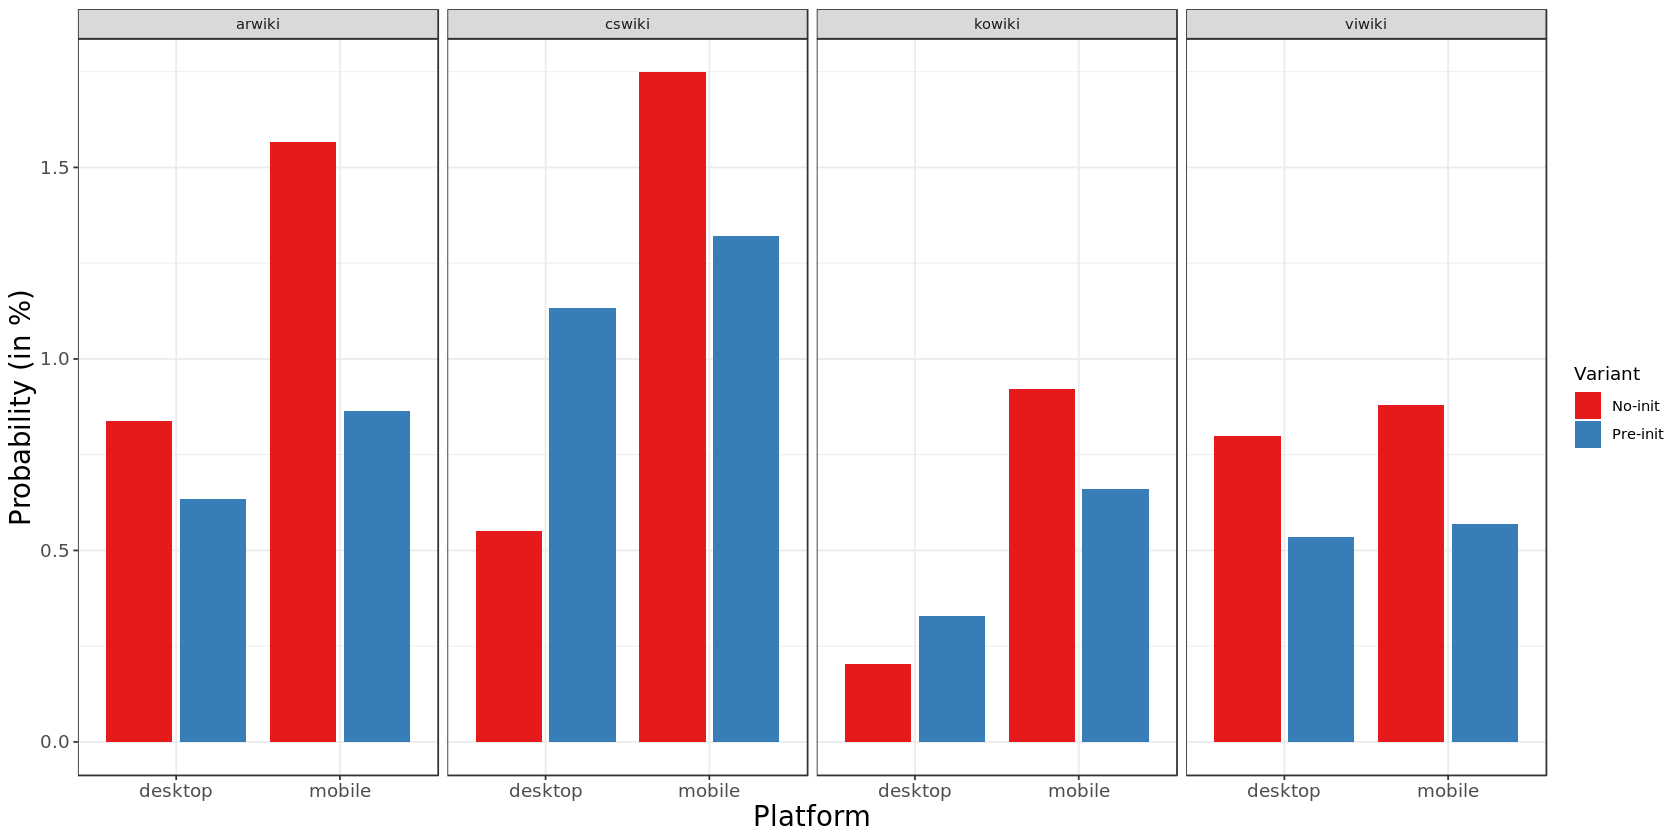

In [102]:
options(repr.plot.width = 14, repr.plot.height = 7)
g = ggplot(merged_counts, aes(x = platform, y = percent_edited, fill = variant)) +
    theme_bw() +
    theme(axis.title.x = element_text(size = rel(1.5)),
        axis.text.x = element_text(size = rel(1.25)),
        axis.title.y = element_text(size = rel(1.5)),
        axis.text.y = element_text(size = rel(1.25))) +
    scale_fill_brewer("Variant", palette = 'Set1', labels = c(A = 'No-init', B = 'Pre-init')) +
    labs(x = "Platform", y = "Probability (in %)") +
    facet_grid(. ~ wiki) +
    geom_col(position = "dodge2")

ggsave(plot = g, file = "graphs/tagged_edit_probabilities.png",
       width = 14, height = 7, units = "in", dpi = "retina")
g

The table displays some of the trends that the regression model also found. Across the board, we see lower probability of making a tagged edit if the user registered on mobile and saw variant B compared to variant A.

On desktop, we see conflicting patterns. Variant B has lower probability of editing on Arabic and Vietnamese Wikipedia, but higher probability on Czech and Korean. This is likely why we find "no difference" overall, because we do not have enough wikis to be able to determine whether these differences are significant from each other.

## Summary

We use data on registrations from launch of the variant A/B test in mid-December 2019 until mid-May 2020 to understand if there is a significant difference in the probability of making a tagged edit. Our dataset contains 68,575 accounts.

Our statistical model indicates that the impact of the variant changes depending on whether the user registered on the desktop or mobile site. On desktop, we find no difference between the two variants. On mobile, we find that variant B has a significantly lower probability of making an edit.

Recommendation: either 1) figure out why variant B performs so much lower on mobile, or 2) give all new registrations variant A.

## Additional analysis

What's the probability difference across the dataset for A vs B?

In [107]:
merged_counts[, list(n_registrations = sum(n_registrations), n_edited = sum(n_edited),
                     perc_edited = 100 * sum(n_edited) / sum(n_registrations)),
              by = c('platform', 'variant')]

platform,variant,n_registrations,n_edited,perc_edited
<fct>,<fct>,<int>,<int>,<dbl>
desktop,A,15039,103,0.6848860
desktop,B,14857,93,0.6259676
mobile,A,19300,272,1.4093264
mobile,B,19379,159,0.8204758


In [108]:
(1.409 - 0.820) / 1.409

[1] 0.418027